In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder("/content/datapath3",
                       transform = T.Compose([
                                              T.Resize(image_size),
                                              T.CenterCrop(image_size),
                                              T.ToTensor(),
                                              T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


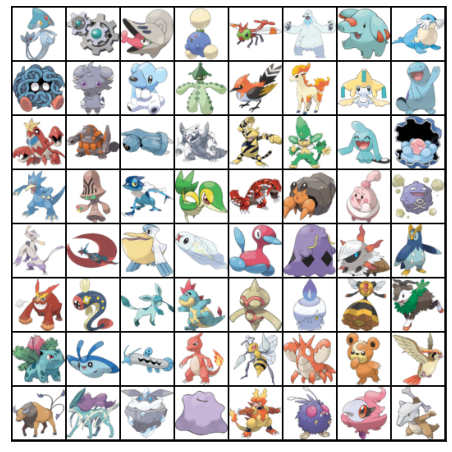

In [5]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

show_batch(train_dl)

In [6]:
import torch.nn as nn

discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, 
              padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, 
              padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, 
              padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, 
              padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=2, 
              padding=1, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid())

In [7]:
latent_size = 128

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4,
                       stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4,
                       stride=2, padding=1, bias=False),
   
   nn.Tanh())

torch.Size([128, 3, 64, 64])


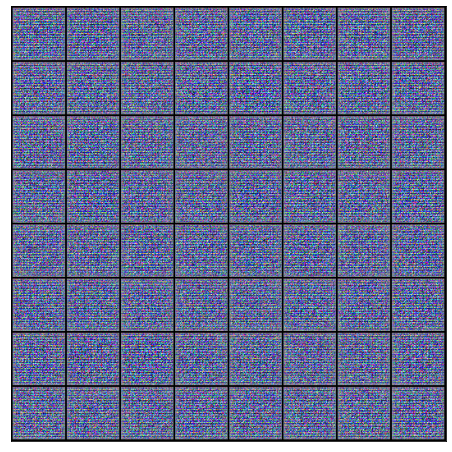

In [8]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [9]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 4)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0), 4)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [10]:
def train_generator(opt_g):
  opt_g.zero_grad()
  
  latent = torch.randn(batch_size, latent_size, 1, 1)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 4)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()

  return loss.item()

In [11]:
from torchvision.utils import save_image

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), fake_fname)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


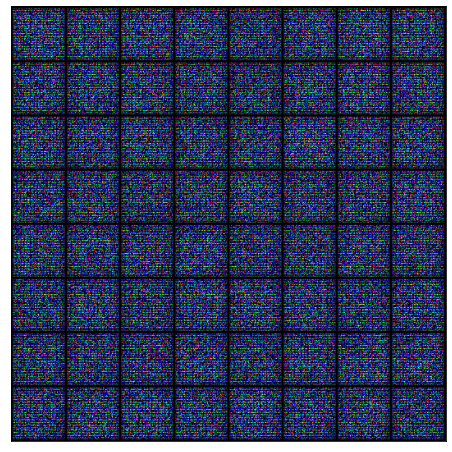

In [12]:
fixed_latent = torch.randn(64, latent_size, 1, 1)
save_samples(0, fixed_latent)

In [14]:
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
  
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr,
                           betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr,
                           betas=(0.5, 0.999))
  
  for epoch in range(epochs):
    for real_images, _ in train_dl:
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    save_samples(epoch+start_idx, fixed_latent, show=False)
    torch.save(generator.state_dict(), "/content/gen.pt")
  return losses_g, losses_d, real_scores, fake_scores

lr = 0.0002
epochs = 200
history = fit(epochs, lr)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/200], loss_g: 4.9226, loss_d: 0.1934, real_score: 0.9176, fake_score: 0.0969
Saving generated-images-0001.png
Epoch [2/200], loss_g: 5.9750, loss_d: 0.0723, real_score: 0.9758, fake_score: 0.0449
Saving generated-images-0002.png
Epoch [3/200], loss_g: 6.2966, loss_d: 0.0382, real_score: 0.9829, fake_score: 0.0201
Saving generated-images-0003.png
Epoch [4/200], loss_g: 6.8640, loss_d: 0.0333, real_score: 0.9882, fake_score: 0.0211
Saving generated-images-0004.png
Epoch [5/200], loss_g: 6.9549, loss_d: 0.0232, real_score: 0.9894, fake_score: 0.0123
Saving generated-images-0005.png
Epoch [6/200], loss_g: 6.9334, loss_d: 0.0195, real_score: 0.9907, fake_score: 0.0099
Saving generated-images-0006.png
Epoch [7/200], loss_g: 7.2881, loss_d: 0.0134, real_score: 0.9950, fake_score: 0.0084
Saving generated-images-0007.png
Epoch [8/200], loss_g: 7.0781, loss_d: 0.0209, real_score: 0.9883, fake_score: 0.0082
Saving generated-images-0008.png
Epoch [9/200], loss_g: 7.5098, loss_d: 0.0140, r